# Trend Classification Green Energy Stocks
# Without Trends Data

### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'

# 1.0 Load data

## 1.1 Load stock data

In [3]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [4]:
traditional_energy_stocks = [ "LNG", "OKE", "BKR", "WMB", "EQT",  "XEC",  "XOM",  "CVX",  "BP",  "OXY",  "COP",  "EOG",  "COG",  "CNQ",  "SLB",  "PTR",  "TOT",  "ENB"]

In [5]:
green_energy_stocks = ["CSIQ", "SPWR", "AQN.TO", "DQ", "HYSR", "PLUG", "SOL", "NEE", "ENPH", "FSLR", "SEDG", "ORA", ]

In [6]:
data = get_data_yf(green_energy_stocks + top_energy, time_period)

[*********************100%***********************]  37 of 37 completed


In [7]:
data.isna().sum().sum()

4830

In [8]:
sum(data.isna().sum(axis=1)>0)

56

In [9]:
data = data.dropna()

In [10]:
sum(data.isna().sum(axis=1)>0)

0

In [11]:
data = process_stock_data_from_yf(data)

In [12]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

## 1.2 Compute technical indicators

In [13]:
all_stock_features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']

In [14]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

## 1.3 Load trends data

In [15]:
filenames = [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [16]:
climate_trends_data = load_climate_data(filenames, terms)

In [17]:
climate_trends_data.shape

(2278, 11)

<AxesSubplot:xlabel='Date'>

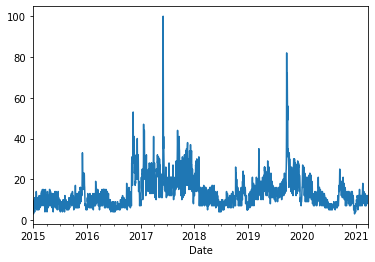

In [18]:
climate_trends_data.set_index('Date')[terms[0]].plot()

### Choose features

In [19]:
chosen_stock_features = ['Close', 'High',
 'Low', 
'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 
#'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 
'WMA', 
'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 
#'DX',
 'PDI', 'NDI', 
'ADX',
 'ROC', 'MACD', 'CCI'
                        ]
# DX and WILLR can cause issues when stock prices don't change, results in lots of nan. 

In [20]:
chosen_trend_terms = [
#     "climate change",
#     "greenhouse gas",
#     "oil",
#     "renewable",
#     "carbon tax",
#     "electric vehicles",
# #     "environmental protection agency",
#     "fossil fuels",
# #     "fracking",
#     "global warming",
]

# 2.0 Model design

In [61]:
num_features = len(chosen_stock_features) + len(chosen_trend_terms) 

In [62]:
reg = 0.002
drop=0.25

model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))
model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(Flatten())

model.add(Dense(5, activation='relu', activity_regularizer=l2(reg)))
model.add(Dropout(drop))


model.add(Dense(1, activation='sigmoid'))

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 75)            30900     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 75)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 14, 30)           

# 3.0 Prepare dataset of many stocks

In [64]:
x_train, y_train, x_valid, y_valid, x_test, y_test = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           green_energy_stocks + top_energy,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [65]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (25351, 14, 27)
y_train: (25351,)
x_valid: (8399, 14, 27)
y_valid (8399,)
x_test: (8436, 14, 27)
y_test (8436,)


## 3.1 Train on many stocks

In [66]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [67]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [68]:
history1 = model.fit(x_train, 
                     y_train, 
                     epochs=15, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
397/397 [==============================] - 16s 29ms/step - loss: 0.6978 - accuracy: 0.5071 - val_loss: 0.6930 - val_accuracy: 0.5285
Epoch 2/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6892 - accuracy: 0.5327 - val_loss: 0.6925 - val_accuracy: 0.5413
Epoch 3/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6890 - accuracy: 0.5327 - val_loss: 0.6946 - val_accuracy: 0.5348
Epoch 4/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6873 - accuracy: 0.5386 - val_loss: 0.7064 - val_accuracy: 0.4846
Epoch 5/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6877 - accuracy: 0.5312 - val_loss: 0.6938 - val_accuracy: 0.5372
Epoch 6/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6856 - accuracy: 0.5397 - val_loss: 0.6988 - val_accuracy: 0.4852
Epoch 7/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6842 - accuracy: 0.5503 - val_loss: 0.7064 - val_accuracy: 0.482

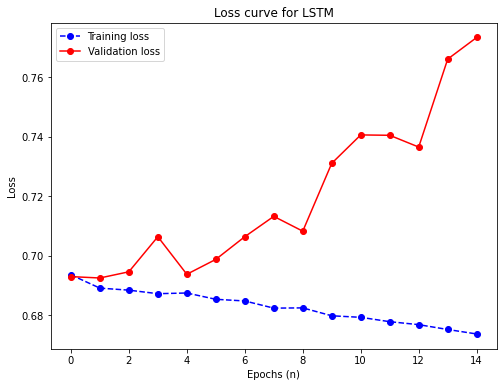

In [69]:
plot_loss(history1)

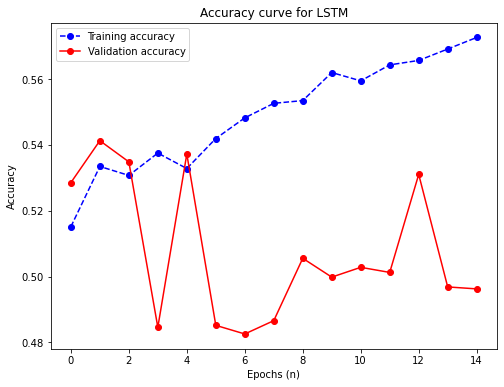

In [70]:
plot_acc(history1)

## 3.2 Performance of model

In [71]:
performance_stats(model, x_train, y_train)

Upward ratio: 50.34%
Mean prediction: 48.19%
Predicted upward ratio: 46.48%
Accuracy: 57.76%


In [72]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 51.70%
Mean prediction: 40.90%
Predicted upward ratio: 16.44%
Accuracy: 49.62%


In [73]:
performance_stats(model, x_test, y_test)

Upward ratio: 50.26%
Mean prediction: 43.40%
Predicted upward ratio: 23.71%
Accuracy: 48.53%


# 4.0 Prepare data for less stocks

In [74]:
x_train2, y_train2, x_valid2, y_valid2, x_test2, y_test2 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           green_energy_stocks,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [75]:
print("x_train: {}".format(x_train2.shape))
print("y_train: {}".format(y_train2.shape))
print("x_valid: {}".format(x_valid2.shape))
print("y_valid {}".format(y_valid2.shape))
print("x_test: {}".format(x_test2.shape))
print("y_test {}".format(y_test2.shape))

x_train: (8201, 14, 27)
y_train: (8201,)
x_valid: (2724, 14, 27)
y_valid (2724,)
x_test: (2736, 14, 27)
y_test (2736,)


## 4.1 Train model on less stocks

In [76]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [77]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [79]:
history2 = model.fit(x_train2, 
                     y_train2, 
                     epochs=15, 
                     validation_data=(x_valid2, y_valid2), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
129/129 [==============================] - 13s 61ms/step - loss: 0.6632 - accuracy: 0.5973 - val_loss: 0.7698 - val_accuracy: 0.5173
Epoch 2/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6528 - accuracy: 0.6201 - val_loss: 0.8183 - val_accuracy: 0.5147
Epoch 3/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6572 - accuracy: 0.6092 - val_loss: 0.7530 - val_accuracy: 0.5349
Epoch 4/15
129/129 [==============================] - 2s 15ms/step - loss: 0.6561 - accuracy: 0.6064 - val_loss: 0.7612 - val_accuracy: 0.5308
Epoch 5/15
129/129 [==============================] - 2s 15ms/step - loss: 0.6465 - accuracy: 0.6195 - val_loss: 0.7972 - val_accuracy: 0.5338
Epoch 6/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6475 - accuracy: 0.6172 - val_loss: 0.8090 - val_accuracy: 0.5286
Epoch 7/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6478 - accuracy: 0.6069 - val_loss: 0.8302 - val_accuracy: 0.534

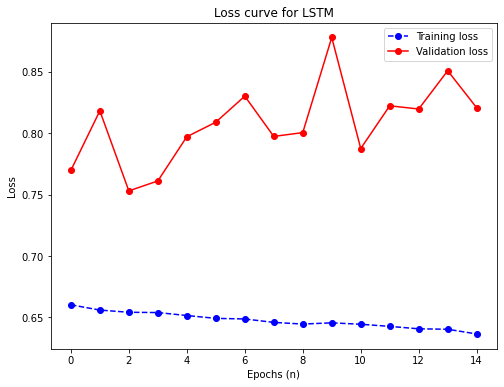

In [80]:
plot_loss(history2)

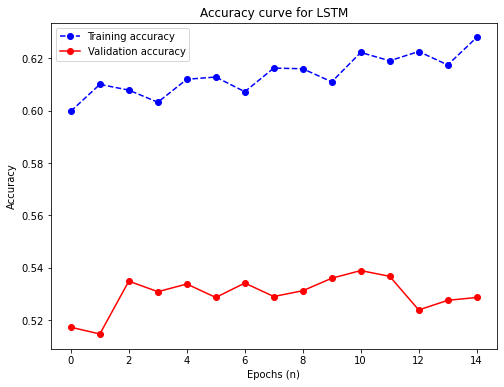

In [81]:
plot_acc(history2)

## 4.2 Performance of model

In [82]:
performance_stats(model, x_train2, y_train2)

Upward ratio: 47.60%
Mean prediction: 49.58%
Predicted upward ratio: 52.04%
Accuracy: 64.35%


In [83]:
performance_stats(model, x_valid2, y_valid2)

Upward ratio: 48.46%
Mean prediction: 48.42%
Predicted upward ratio: 45.01%
Accuracy: 52.86%


In [84]:
performance_stats(model, x_test2, y_test2)

Upward ratio: 55.23%
Mean prediction: 45.08%
Predicted upward ratio: 42.11%
Accuracy: 50.04%


Text(0.5, 1.0, 'Testing confusion matrix')

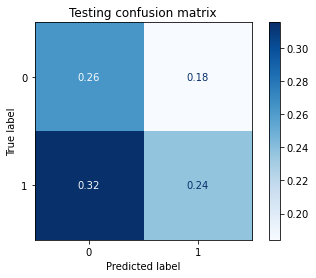

In [85]:
cm = confusion_matrix(y_true=y_test2, 
                      y_pred=model.predict(x_test2)>0.5,
                     normalize="all")

ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Testing confusion matrix")

In [86]:
print(classification_report(y_true = y_test2,
                     y_pred = model.predict(x_test2)>0.5))

              precision    recall  f1-score   support

           0       0.46      0.59      0.51      1225
           1       0.56      0.43      0.49      1511

    accuracy                           0.50      2736
   macro avg       0.51      0.51      0.50      2736
weighted avg       0.51      0.50      0.50      2736



# 5.0 Prepare data for one stock

In [87]:
green_energy_stocks[0]

'CSIQ'

In [88]:
x_train3, y_train3, x_valid3, y_valid3, x_test3, y_test3 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           [green_energy_stocks[0]],
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [89]:
print("x_train: {}".format(x_train3.shape))
print("y_train: {}".format(y_train3.shape))
print("x_valid: {}".format(x_valid3.shape))
print("y_valid {}".format(y_valid3.shape))
print("x_test: {}".format(x_test3.shape))
print("y_test {}".format(y_test3.shape))

x_train: (686, 14, 27)
y_train: (686,)
x_valid: (227, 14, 27)
y_valid (227,)
x_test: (228, 14, 27)
y_test (228,)


## 5.1 Train model on one stock

In [90]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [91]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
tensorboard = TensorBoard(log_dir='logs/{}_3'.format(time_stamp))

In [101]:
history3 = model.fit(x_train3, 
                     y_train3, 
                     epochs=5, 
                     validation_data=(x_valid3, y_valid3), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/5
11/11 [==============================] - 5s 488ms/step - loss: 0.6141 - accuracy: 0.6487 - val_loss: 0.7331 - val_accuracy: 0.5066
Epoch 2/5
11/11 [==============================] - 0s 18ms/step - loss: 0.6053 - accuracy: 0.6749 - val_loss: 0.7426 - val_accuracy: 0.4890
Epoch 3/5
11/11 [==============================] - 0s 18ms/step - loss: 0.6115 - accuracy: 0.6472 - val_loss: 0.7102 - val_accuracy: 0.5022
Epoch 4/5
11/11 [==============================] - 0s 18ms/step - loss: 0.6183 - accuracy: 0.6531 - val_loss: 0.7795 - val_accuracy: 0.4802
Epoch 5/5
11/11 [==============================] - 0s 18ms/step - loss: 0.6022 - accuracy: 0.6720 - val_loss: 0.7056 - val_accuracy: 0.5727


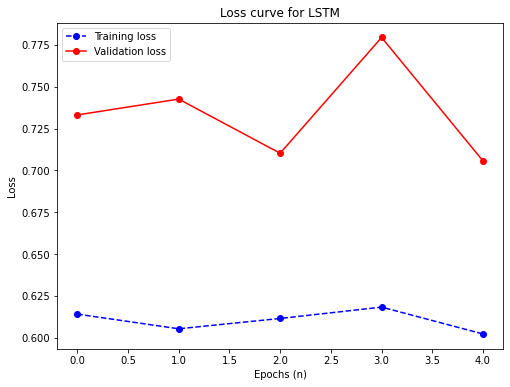

In [102]:
plot_loss(history3)

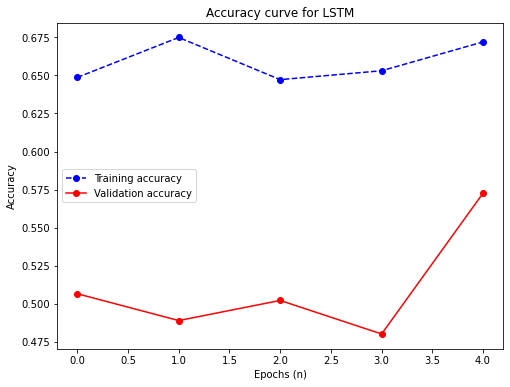

In [103]:
plot_acc(history3)

## 5.2 Performance of model

In [104]:
performance_stats(model, x_train3, y_train3)

Upward ratio: 50.29%
Mean prediction: 51.57%
Predicted upward ratio: 54.66%
Accuracy: 71.14%


In [105]:
performance_stats(model, x_valid3, y_valid3)

Upward ratio: 56.83%
Mean prediction: 49.10%
Predicted upward ratio: 51.10%
Accuracy: 57.27%


In [106]:
performance_stats(model, x_test3, y_test3)

Upward ratio: 54.82%
Mean prediction: 46.92%
Predicted upward ratio: 40.35%
Accuracy: 52.19%


Text(0.5, 1.0, 'Testing confusion matrix')

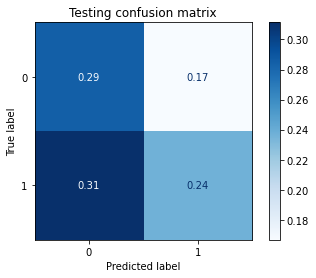

In [107]:
cm = confusion_matrix(y_true=y_test3, 
                      y_pred=model.predict(x_test3 )>0.5,
                     normalize="all")

ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Testing confusion matrix")

In [108]:
print(classification_report(y_true = y_test3,
                     y_pred = model.predict(x_test3)>0.5))

              precision    recall  f1-score   support

           0       0.48      0.63      0.54       103
           1       0.59      0.43      0.50       125

    accuracy                           0.52       228
   macro avg       0.53      0.53      0.52       228
weighted avg       0.54      0.52      0.52       228

